In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output

In [2]:
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import pickle
from collections import defaultdict

from skimage.segmentation import mark_boundaries
from glob import glob
import pandas as pd
import scipy
import cv2
import joblib

from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
import torch
from torch.utils.data.sampler import Sampler
import torch.nn.functional as F

In [4]:
CUDA_IDX = 0
torch.cuda.set_device(CUDA_IDX)

In [5]:
import sys
sys.path.append('../torch_utils/')
sys.path.append('../utils')
sys.path.append('../zoo')
import rles
import dataset as ds
%load_ext autoreload
%autoreload 2
import ternaus_net
%load_ext autoreload
%autoreload 2
import enorm
%load_ext autoreload
%autoreload 2
import augmentations as augs
%load_ext autoreload
%autoreload 2
import learner as lrnr
%load_ext autoreload
%autoreload 2
import torch_funcs as thf
%load_ext autoreload
%autoreload 2
import losses
import metrics
import visualisation
import nms
%load_ext autoreload
%autoreload 2
import map_iou
import lr_finder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# from retinanet import model as retinanet
import retinanet.resnext
import retinanet.model
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
PATHS = {
    'DATA': '../data/',
    'MASKS': '../data/masks/',
    'ARCHIVE': '../data/indianapolis/',
    'TRAIN': '../data/train',
    'TEST': '../data/test',
    'TEST2': '../data/test2',
    'CSV': '../data/csv',
}

PARAMS = {
    'PATHS': PATHS,
    'SEED': 42,
    'NB_FOLDS': 4,
    'PNG_SIDE': 512,
    'CUDA_DEVICES': [0, 1],
    'INVERSE': 3,
    'BATCH_SIZE': 22,
    'NB_EPOCHS': 31,
    'LR': 1e-5,
    'EXP_GAMMA': .8,
    'CUDA_DEVICES': [0, 1],
}

In [8]:
mpaths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))
ipaths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))

separate = lambda x: os.path.basename(x)
ipaths = [separate(path) for path in ipaths]
mpaths = [separate(path) for path in mpaths]

paths = list(set(mpaths).intersection(ipaths))
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [9]:
mpaths = glob(os.path.join(PATHS['TEST'], 'png', '*.png'))
ipaths = glob(os.path.join(PATHS['TEST'], 'png', '*.png'))

separate = lambda x: os.path.basename(x)
ipaths = [separate(path) for path in ipaths]
mpaths = [separate(path) for path in mpaths]

paths = list(set(mpaths).intersection(ipaths))
paths_df_val = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df_val = pd.DataFrame(paths_df_val)

In [10]:
ddf = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_2_detailed_class_info.csv'))
ddf = ddf.drop_duplicates()
class_to_num = {
    'No Lung Opacity / Not Normal': 2, 
    'Lung Opacity': 1, 
    'Normal': 0
}
num_to_class = {
    2: 'No Lung Opacity / Not Normal', 
    1: 'Lung Opacity', 
    0: 'Normal'
}

ddf['class'] = ddf['class'].apply(lambda x: class_to_num[x])
ddf.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [11]:
df = pd.read_csv(os.path.join(PATHS['CSV'], 'stage_2_train_labels.csv'))
df = df.dropna().drop(['Target'], axis=1)
df.head()

,patientId,x,y,width,height
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0


# DONT FORGET TO SHUFFLE TRAIN

In [10]:
def get_datagens(fold, paths_df, df, class_ddf, val_to_train=0, max_negatives=None):
    paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])

    paths_fold, paths_rest = ds.get_fold(paths, fold=fold, nb_folds=PARAMS['NB_FOLDS'], seed=42)
    if val_to_train:
        keys = sorted(list(paths_fold.keys()))
        rs = np.random.RandomState(seed=42)
        rs.shuffle(keys)
        for key in keys[:int(len(keys) * val_to_train)]:
            paths_rest[key] = paths_fold.pop(key)
        

    augments = augs.BBoxesAugmentation(side=512, strength=1.)
    augments_val = augs.BBoxesAugmentation(side=768, strength=0)
    dataset_train = ds.BBoxDataset(paths_rest, df, class_ddf, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.BBoxDataset(paths_fold, df, class_ddf, augments_val)
    esmplr = ds.EqualizedSampler(dataset_train, class_ddf, max_negatives=max_negatives)
    vsmplr = ds.ValSampler(dataset_val)
    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                sampler=esmplr,
                                                collate_fn=ds.bbox_collater,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=4)

    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              pin_memory=False,
                                              sampler=vsmplr,
                                              collate_fn=ds.bbox_collater,
                                              batch_size=PARAMS['BATCH_SIZE'],
                                              num_workers=0)
    return train_datagen, val_datagen

In [13]:
def orchestrate(learner, train_datagen, val_datagen, df=None,
                epchs_per_save=10,
                fold=0, epochs=1, hard_negative_miner=None,
                checkpoints_pth='../data/', lr_scheduler=None, 
                history=None, verbose=True, nb_freezed_epchs=0):

    if checkpoints_pth is not None:
        path = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')
    if history is None:
        history = defaultdict(list)
    try:
        os.mkdir(checkpoints_pth)
    except:
        pass
    last_epoch = len(history['train_losses'])
    print('last_epoch: {}'.format(last_epoch))

    ou = np.array([val_datagen.dataset.load_label(key) for key in tqdm(val_datagen.dataset.keys)])
    coeff = ou.sum(axis=0)[1] / ou.sum()
    print('coeff: {}'.format(coeff))

    for epoch_i in range(last_epoch, epochs):
        if hasattr(lr_scheduler, 'step'):
            lr_scheduler.step()
        learner.freeze_encoder(unfreeze=(epoch_i >= nb_freezed_epchs))

        meters = learner.train_on_epoch(
            train_datagen, 
            hard_negative_miner=hard_negative_miner,
            lr_scheduler=lr_scheduler
        )
        history['train_losses'].append(meters)

        meters = learner.validate(val_datagen)
        bbx_results = [m['results'] for m in meters]
        clf_results = None
        if 'clf_out' in meters[0].keys():
            clf_results = [m['clf_out'].numpy() for m in meters]
            clf_results = np.array(clf_results).squeeze()

        iou, threshold = map_iou.compute_maps(df, bbx_results, clf_results, coeff=coeff)

        meters = [{k: v for k, v in m.items() if k != 'results'} for m in meters]
        history['val_losses'].append({
            'meters': metrics.aggregate(meters),
            'iou': iou,
        })

        clear_output(wait=True)
        if verbose:
            visualisation.plot_retina_losses(history)
            print('Threshold: {}'.format(threshold))
            print(checkpoints_pth)
#             for i, el in enumerate(dist):
#                 print('{}\t--\t{}'.format(num_to_class[i], el))

            learner.infer_on_data(val_datagen.dataset[6], df, threshold=threshold)
            learner.infer_on_data(val_datagen.dataset[113], df, threshold=threshold)
            learner.infer_on_data(val_datagen.dataset[200], df, threshold=threshold)
#             if train_dataset.aug_params['strength'] > min_strength:
#                 train_dataset.aug_strength_decay(strength_decay)

        if (checkpoints_pth is not None) and ((iou >= max([vl['iou'] for vl in history['val_losses']])) or ((epoch_i) % epchs_per_save == 0) or (epoch_i == epochs - 1)):
            state_dict = learner.model.state_dict()
            if isinstance(learner.model, torch.nn.DataParallel):
                state_dict = learner.model.module.state_dict()
            torch.save(state_dict, 
                       path.format(fold, epoch_i))
            print(path.format(fold, epoch_i))
        if checkpoints_pth is not None:
            pickle.dump(history, open(path.format(fold, 'loss'), 'wb'))
            pickle.dump([bbx_results, clf_results], open(path.format(fold, 'results_{}'.format(epoch_i)), 'wb'))
#         train_dataset.converge_appearence(decay=converge_appearence)

    return learner, history

In [14]:
class RetinaLearner(lrnr.Learner):
    def __init__(self, model, loss, clf_loss=None, opt=None, metrics=[], ignored_keys=[], clf_reg_alpha=.5, betta=.5, gclip=0.001):
        self.alpha = clf_reg_alpha
        self.clf_loss = clf_loss
        self.betta = betta
        self.gclip = gclip
        self.threshold = 0.05
        super(RetinaLearner, self).__init__(model, loss, opt, metrics, ignored_keys)

    def make_step(self, data, training=False):
        image = torch.autograd.Variable(data['img']).cuda()
        annot = data['annot']
        if len(image.shape) == 3:
            image = image.float().unsqueeze(dim=0)

        if len(data['label'].shape) == 1:
            data['label'] = torch.tensor(data['label']).float().unsqueeze(dim=0)

        if len(annot.shape) == 2:
            if annot.shape[0] == 0:
                annot = torch.ones(1, 5) * -1
            annot = torch.tensor(annot).unsqueeze(dim=0)
        output = self.model([
            image.float(), 
            annot.float()
        ])
        classification_loss, regression_loss = output['focal_loss']
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        results = { 
            'loss': self.alpha * classification_loss + (1 - self.alpha) * regression_loss,
            'bbx_reg_loss': regression_loss,
            'bbx_clf_loss': classification_loss,
        }

        if 'clf_out' in output.keys():
            clfl = clf_loss(output['clf_out'].float(), torch.tensor(data['label']).cuda().float())
            clf_results = {
                'clf_loss': torch.mean(clfl),
                'clf_out': output['clf_out'],
            }
            results.update(clf_results)
            results['loss'] = (self.betta * results['loss'] + (1 - self.betta) * results['clf_loss'])

        if 'nms_out' in output.keys():
            scores, labels, boxes = output['nms_out']
            results.update({ 
                'results': [{ 'image_id': data['pid'], 'score': 0 }]
            })
            if boxes.shape[1] == 4:
                results['results'] = self.process_bboxes(data, scores, labels, boxes)
                results['results'] = [{k: v.data.cpu() if hasattr(v, 'data') else v for k, v in r.items()} for r in results['results']]

        if training and bool((classification_loss + regression_loss) == 0):
            image = image.data.cpu()
            for key in results.keys():
                if key != 'results':
                    results[key] = results[key].data.cpu()
            return results

        if training:
            results['loss'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.gclip)
            self.opt.step()
#         for metric in self.metrics:
#             losses.update(metric(regression_loss, data['annot']))
        image = image.data.cpu()
        for key in results.keys():
            if key != 'results':
                results[key] = results[key].data.cpu()
        return results

    def validate(self, datagen):
        self.model.eval()
        meters = list()

        with torch.no_grad():
            for data in tqdm(datagen.dataset):
                meters.append(self.make_step(data, training=False))

        return meters

    def freeze_encoder(self, unfreeze=False):
        if hasattr(self.model, 'module'):
            model_ = self.model.module
        elif hasattr(self.model, 'encoder'):
            model_ = self.model
        encoders = [
            model_.conv1,
            model_.layer1,
            model_.layer2,
#             model_.layer3,
#             model_.layer4,
        ]
        for encoder in encoders:
            thf.freeze(encoder, unfreeze=unfreeze)
            thf.unfreeze_bn(encoder)

    def process_bboxes(self, data, scores, labels, boxes):
        results = list()
        # compute predicted labels and scores
        #for box, score, label in zip(boxes[0], scores[0], labels[0]):
        for box_id, box in enumerate(boxes):
            score = float(scores[box_id])
            label = int(labels[box_id])

            # scores are sorted, so we can break
            if score < self.threshold:
                break

            # append detection for each positively labeled class
            image_result = {
                'image_id'    : data['pid'],
                'category_id' : int(label),
                'score'       : float(score),
                'bbox'        : box.tolist(),
            }

            # append detection to results
            results.append(image_result)
        return results

    def infer_on_data(self, data, df, verbose=True, k=2, threshold=.5):
        if self.model.training:
            self.model.eval()

        with torch.no_grad():
            result = self.make_step(data, training=False)
        image = data['img'].data.cpu().numpy() * ds.STD + ds.MEAN
        image = np.moveaxis(image, 0, -1)
        if verbose:
            scores_over_thresh = np.array([k['score'] > .05 for k in result['results'] if k['score']])
            uzft = np.array([
                np.concatenate([
                    [k['score']], k['bbox']
                ], axis=0) 
                if len(k['bbox']) else
                np.zeros((5, ))
                for k in result['results']
            ])[scores_over_thresh]
            uzft = np.concatenate([np.ones((uzft.shape[0], 1)), uzft], axis=1)

            chosen = list()
            for i in range(4):
                if len(uzft) == 0:
                    break
                ref_bbx = uzft[np.argmax(uzft[:, 1])]
                if ref_bbx[1] < threshold:
                    break
                zious = np.array([map_iou.iou(ref_bbx[2:], u[2:]) for u in uzft])
                selected = ref_bbx[2:]
                chosen.append(np.concatenate([ref_bbx[:2], selected]))
                uzft = uzft[zious < .2]

            chosen = np.array(chosen)

            if (not len(uzft)) or (not len(chosen)):
                top_k_annots = np.zeros((0, 4))
                score = []
            else:
                top_k_annots = chosen[:, 2:]
                score = chosen[:, 1]

            print(score)
            if 'clf_out' in result.keys():
                print(torch.nn.functional.softmax(result['clf_out']))
                print(data['label'])

            data_pred = {
                'img': image,
                'annot': top_k_annots.astype(np.int),
            }

            key = data['pid'].split('.')[0]
            annot = df.query('patientId==@key').drop(['patientId'], axis=1).values.astype(np.int)
            annot[:, 2] += annot[:, 0]
            annot[:, 3] += annot[:, 1]
            data_annot = {
                'img': image,
                'annot': annot,
            }
            visualisation.visualize_bboxes(data_pred, data_annot, {1: 'png'})
        
        return result

In [15]:
clf_loss = torch.nn.BCEWithLogitsLoss()

In [16]:
def get_param_sets(model):
    param_set1_ = [model.module.conv1, model.module.bn1, model.module.relu, model.module.maxpool, model.module.layer1, model.module.layer2]
    param_set2_ = [model.module.layer3, model.module.layer4]

    param_set1 = list()
    for p in param_set1_:
        param_set1.extend(list(p.parameters()))

    param_set2 = list()
    for p in param_set2_:
        param_set2.extend(list(p.parameters()))
    param_set3 = list(model.module.parameters())[len(param_set1) + len(param_set2):]

    print(len(param_set1))
    print(len(param_set2))
    print(len(param_set3))
    return param_set1, param_set2, param_set3

# JUHUU

In [17]:
mpaths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))
ipaths = glob(os.path.join(PATHS['TRAIN'], 'png', '*.png'))

separate = lambda x: os.path.basename(x)
ipaths = [separate(path) for path in ipaths]
mpaths = [separate(path) for path in mpaths]

paths = list(set(mpaths).intersection(ipaths))
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [18]:
df[['x', 'y', 'width', 'height']] /= 2
lr_police = [[0, 5e-5], [8, 1e-5], [12, 5e-6], [15, 1e-6]]

In [19]:
def get_datagens(paths_df, paths_df_val, df, class_ddf, max_negatives=None):
    paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])
    paths_val = ds.get_paths(paths_df_val, root_dir=PATHS['TEST'])

    paths_rest, _ = ds.get_fold(paths, fold=0, nb_folds=1, seed=42)
    paths_fold, _ = ds.get_fold(paths_val, fold=0, nb_folds=1, seed=42)

    augments = augs.BBoxesAugmentation(side=512, strength=1.)
    augments_val = augs.BBoxesAugmentation(side=512, strength=0)
    dataset_train = ds.BBoxDataset(paths_rest, df, class_ddf, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.BBoxDataset(paths_fold, df, class_ddf, augments_val)
    esmplr = ds.EqualizedSampler(dataset_train, class_ddf, max_negatives=max_negatives)
    vsmplr = ds.ValSampler(dataset_val)
    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                sampler=esmplr,
                                                collate_fn=ds.bbox_collater,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=4)

    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              pin_memory=False,
                                              sampler=vsmplr,
                                              collate_fn=ds.bbox_collater,
                                              batch_size=PARAMS['BATCH_SIZE'],
                                              num_workers=0)
    return train_datagen, val_datagen

In [20]:
def train_proc(model, fold, checkpoints_pth, train_datagen, val_datagen, lr_police=None):
    if lr_police is None:
        lr_police = [[0, 5e-5], [8, 1e-5], [12, 5e-6], [45, 1e-6]]

    history_pth = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold))
    history = None
    if os.path.isfile(history_pth):
        history = pickle.load(open(history_pth, 'rb'))

    for cll in range(len(lr_police) - 1):
        opt = torch.optim.Adam(model.parameters(), lr=lr_police[cll][1])

        learner = RetinaLearner(model=model, opt=opt, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])
        last_epoch = -1
        if history is not None:
            n = len(history['val_losses'])
            last_epoch = n - max([ln[0] for ln in lr_police if ln[0] <= n]) - 1
        print('last_epoch: {}'.format(last_epoch))
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=.85, last_epoch=last_epoch)
        learner, history = orchestrate(
            learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=lr_police[cll + 1][0], epchs_per_save=3,
            lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
            history=history, nb_freezed_epchs=0, df=df,
        )
    return learner

In [23]:
def finetune_proc(model, fold, checkpoints_pth, train_datagen, val_datagen, finetune_epchs=1, opt=None, lr_scheduler=None, history=None):
    learner = RetinaLearner(model=model, opt=opt, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])
    last_epoch = -1
    if history is not None:
        last_epoch = len(history['val_losses'])
    print('last_epoch: {}'.format(last_epoch))

    learner, history = orchestrate(
        learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=last_epoch + finetune_epchs, epchs_per_save=3,
        lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
        history=history, nb_freezed_epchs=0, df=df,
    )
    return learner

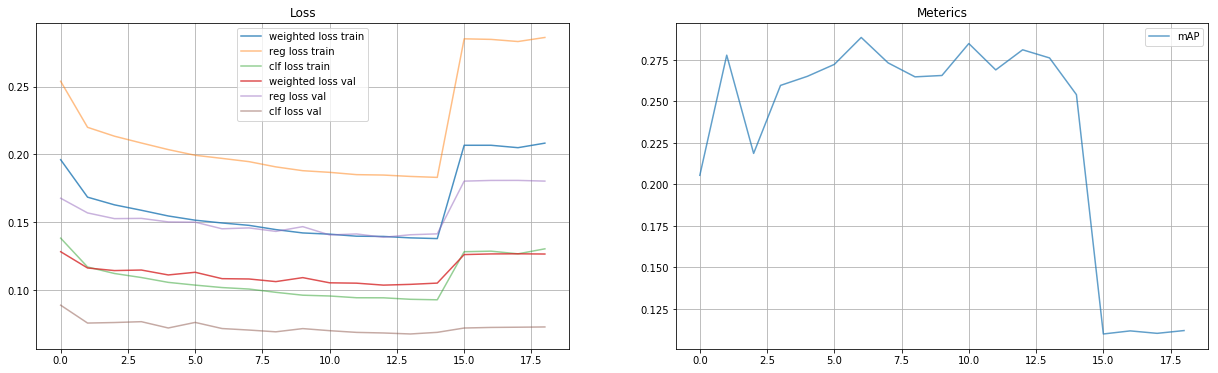

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Threshold: 0.4491788446903229
../data/models/retinanet_resnet50_no_clf_last_wd/
[]


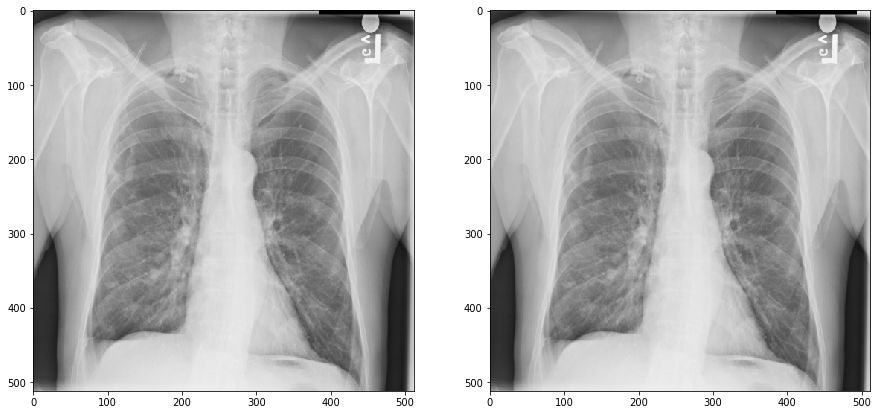

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


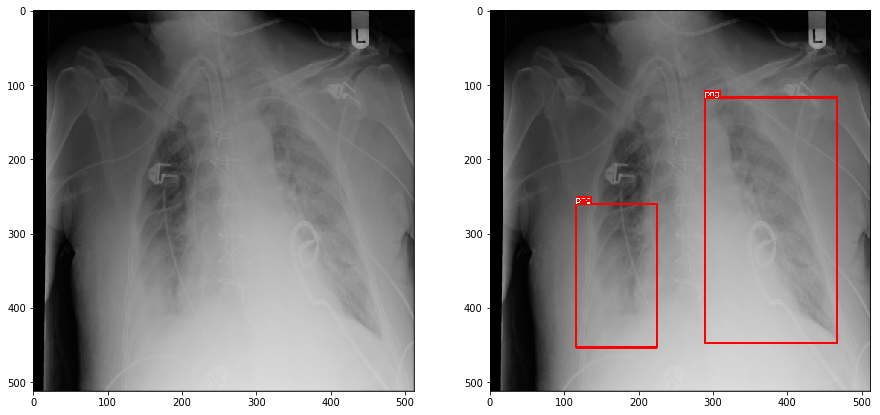

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


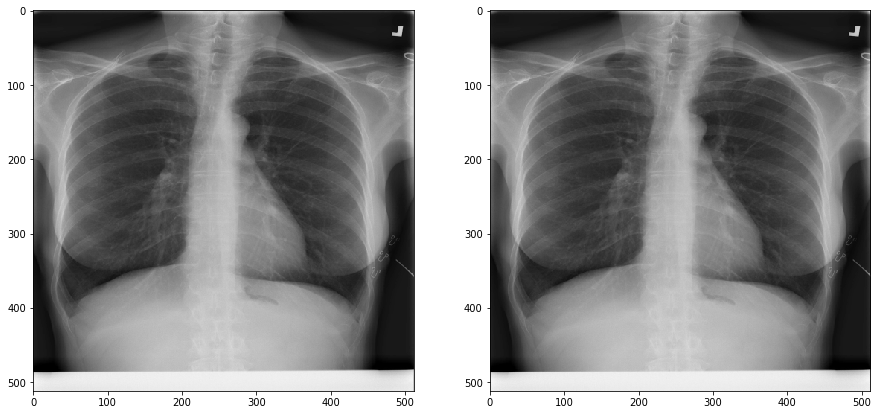

../data/models/retinanet_resnet50_no_clf_last_wd/fold_1_checkpoint.epoch_18


In [27]:
last_epochs = {
    0: 14,
    1: 14,
}

checkpoints_pth = '../data/models/retinanet_resnet50_no_clf_last_wd/'
postfix='resnet50_no_clf_last_wd'

for fold in range(2):
    paths = ds.get_paths(paths_df_val, root_dir=PATHS['TEST'])
    paths_val = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])

    paths_rest, _ = ds.get_fold(paths, fold=0, nb_folds=1, seed=42)
    paths_fold, _ = ds.get_fold(paths_val, fold=fold, nb_folds=4, seed=42)

    augments = augs.BBoxesAugmentation(side=512, strength=1.)
    augments_val = augs.BBoxesAugmentation(side=512, strength=0)
    dataset_train = ds.BBoxDataset(paths_rest, df, ddf, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.BBoxDataset(paths_fold, df, ddf, augments_val)
    esmplr = ds.EqualizedSampler(dataset_train, ddf, max_negatives=None)
    vsmplr = ds.ValSampler(dataset_val)
    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                sampler=esmplr,
                                                collate_fn=ds.bbox_collater,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=4)

    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              pin_memory=False,
                                              sampler=vsmplr,
                                              collate_fn=ds.bbox_collater,
                                              batch_size=PARAMS['BATCH_SIZE'],
                                              num_workers=0)
# ############################################################################################################
    history_pth = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold))
    history = None
    if os.path.isfile(history_pth):
        history = pickle.load(open(history_pth, 'rb'))
        history['train_losses'] = history['train_losses'][: last_epochs[fold] + 1]
        history['val_losses'] = history['val_losses'][: last_epochs[fold] + 1]

    focal_loss = retinanet.losses.FocalLoss(iou_lower=.2, iou_upper=.4)
    model = retinanet.model.resnet50(num_classes=1, focal_loss=focal_loss, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epochs[fold])), devices=PARAMS['CUDA_DEVICES'])

    opt = torch.optim.Adam(model.parameters(), lr=5e-5)

    lr_scheduler = lr_finder.LRFinder(optimizer=opt, max_lr=5e-6 ** (last_epochs[fold] - 12), min_lr=5e-6 ** (last_epochs[fold] + 10 - 12), steps_per_epoch=len(train_datagen), epochs=4)

    finetune_proc(model, fold, checkpoints_pth, train_datagen=train_datagen, val_datagen=val_datagen, finetune_epchs=4, opt=opt, lr_scheduler=lr_scheduler, history=history)

In [21]:
for data in train_datagen:
    break

NameError: name 'train_datagen' is not defined

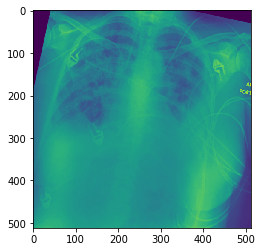

In [30]:
plt.imshow(train_datagen.dataset[21]['img'][0])

In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet50_no_clf_last/'

for fold in range(4):
    train_datagen, val_datagen = get_datagens(fold, paths_df, df, ddf)

    model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

    train_proc(model, fold, checkpoints_pth, train_datagen, val_datagen)

In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet50_no_clf_last/'
lr = 1e-6
last_epoch = 14
fine_tune_epochs = 22
val_to_train = .8
max_negatives = 4200

for fold in range(3):
    history_pth = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold))
    history = pickle.load(open(history_pth, 'rb'))
    history['val_losses'] = history['val_losses'][:last_epoch + 1]
    history['train_losses'] = history['train_losses'][:last_epoch + 1]
    
    train_datagen, val_datagen = get_datagens(fold, paths_df, df, ddf, val_to_train, max_negatives=max_negatives)
    model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    learner = RetinaLearner(model=model, opt=opt, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

#     n = len(history['val_losses'])
#     le = n - max([ln[0] for ln in lr_police if ln[0] < n]) - 1
    le = -1
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=.85, last_epoch=le)
    print('last_epoch for lr_scheduler: {}'.format(le))

    learner, _ = orchestrate(
        learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=fine_tune_epochs, epchs_per_save=3,
        lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
        history=history, nb_freezed_epchs=0, df=df,
    )


In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay/'

train_datagen, val_datagen = get_datagens(paths_df, paths_df_val, df, ddf)
focal_loss = retinanet.losses.FocalLoss(iou_lower=.2, iou_upper=.4)

model = retinanet.model.resnet101(num_classes=1, focal_loss=focal_loss, pretrained=True, single_channel=True, make_clf=False)
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

train_proc(model, 0, checkpoints_pth, train_datagen, val_datagen, lr_police=[[0, 1e-5], [45, 1e-6]])

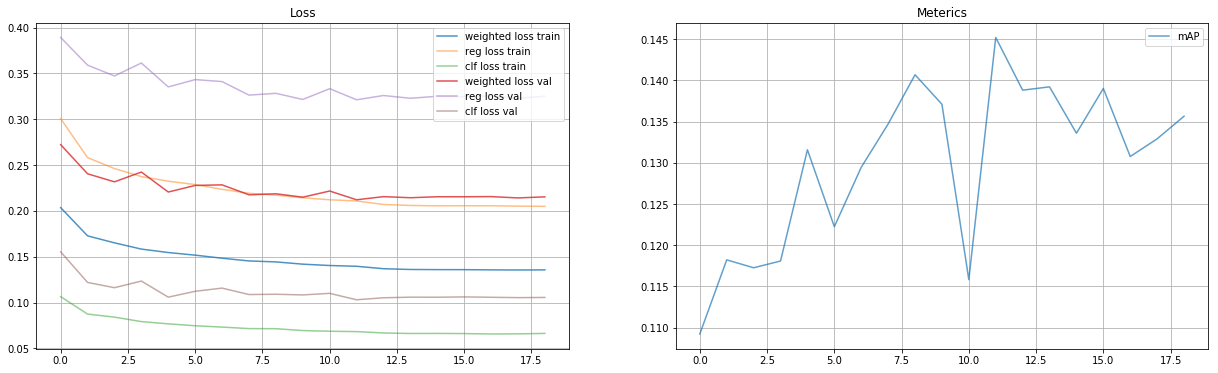

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Threshold: 0.5326222777366638
../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay_from_epoch_11/
[0.65471661 0.61223733]


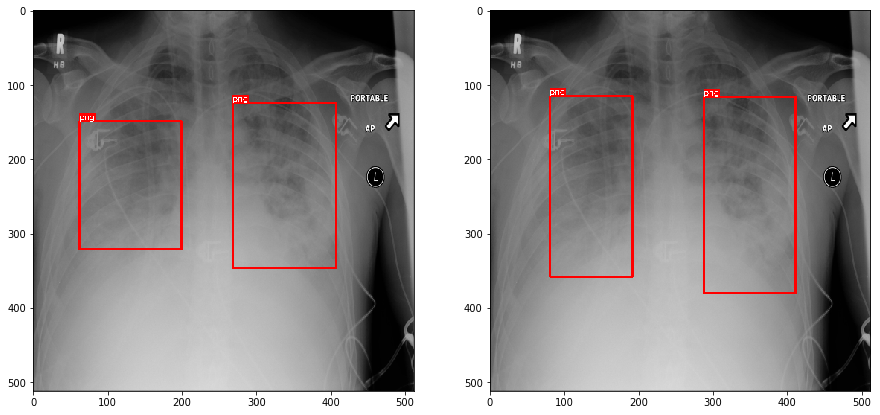

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.56918645]


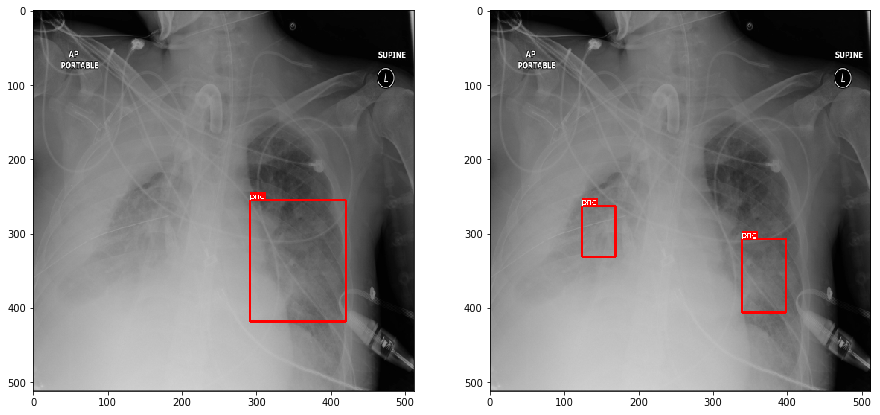

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.63887668]


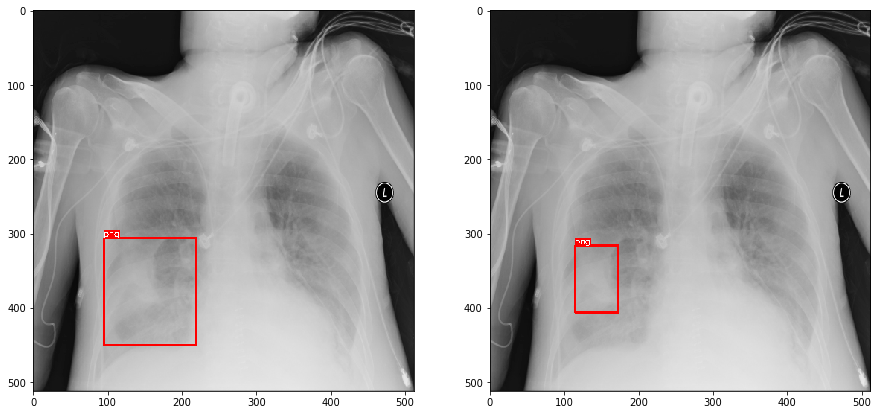

  0%|          | 0/849 [00:00<?, ?it/s]

../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay_from_epoch_11/fold_0_checkpoint.epoch_18


 21%|██▏       | 182/849 [02:31<09:13,  1.20it/s]

In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay_from_epoch_11/'

train_datagen, val_datagen = get_datagens(paths_df, paths_df_val, df, ddf)
focal_loss = retinanet.losses.FocalLoss(iou_lower=.2, iou_upper=.4)

model = retinanet.model.resnet101(num_classes=1, focal_loss=focal_loss, pretrained=True, single_channel=True, make_clf=False)
model = thf.get_model(model, checkpoint='../data/models/retinanet_resnet101_no_clf_last_____lr_pure_decay/fold_0_checkpoint.epoch_11', devices=PARAMS['CUDA_DEVICES'])

train_proc(model, 0, checkpoints_pth, train_datagen, val_datagen, lr_police=[[0, 5e-6], [100, 1e-6]])

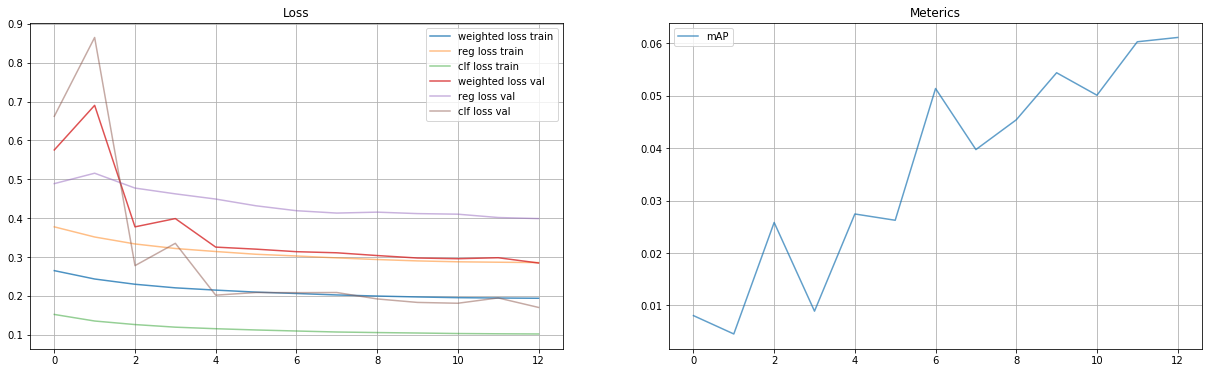

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Threshold: 0.6046501398086548
../data/models/retinanet_wideresnext50_no_clf_last____/
[0.64584261]


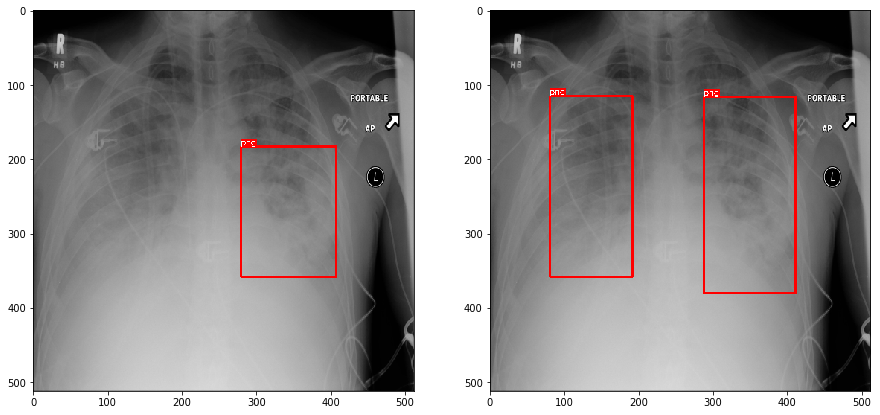

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


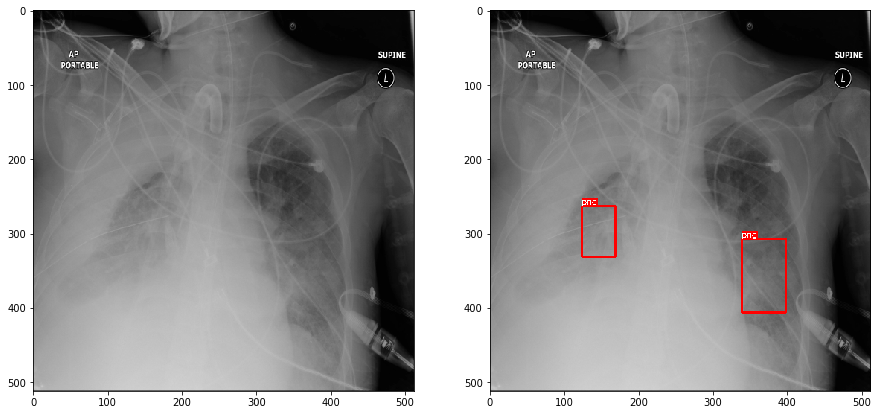

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.6395179]


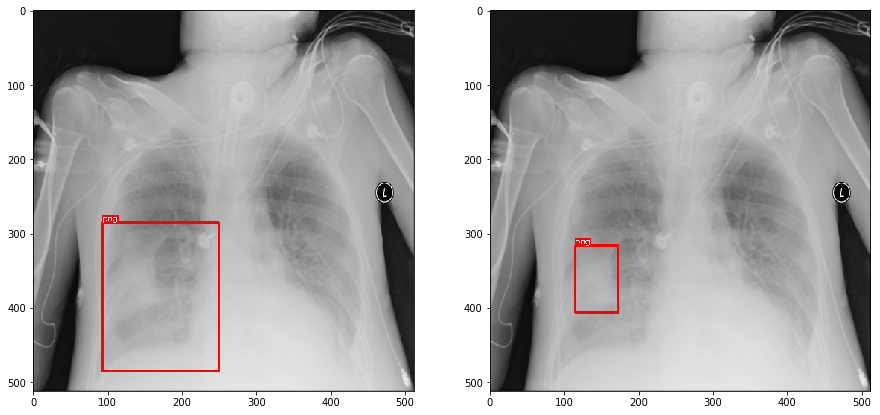

../data/models/retinanet_wideresnext50_no_clf_last____/fold_0_checkpoint.epoch_12


 79%|███████▉  | 1122/1415 [11:49<03:05,  1.58it/s]

In [ ]:
PARAMS.update({
    'BATCH_SIZE': 12,
})

checkpoints_pth = '../data/models/retinanet_wideresnext50_no_clf_last____/'

train_datagen, val_datagen = get_datagens(paths_df, paths_df_val, df, ddf)
focal_loss = retinanet.losses.FocalLoss(iou_lower=.2, iou_upper=.4)

model = retinanet.resnext.resnext50(num_classes=1, focal_loss=focal_loss)
model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])
 
train_proc(model, fold=0, checkpoints_pth=checkpoints_pth, train_datagen=train_datagen, val_datagen=val_datagen)

In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last/'
lr = 1e-6
last_epoch = 14
fine_tune_epochs = 18
val_to_train = .8
max_negatives = 4200

for fold in range(4):
    history_pth = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold))
    history = pickle.load(open(history_pth, 'rb'))
    history['val_losses'] = history['val_losses'][:last_epoch + 1]
    history['train_losses'] = history['train_losses'][:last_epoch + 1]
    
    train_datagen, val_datagen = get_datagens(fold, paths_df, df, ddf, val_to_train, max_negatives=max_negatives)
    model = retinanet.model.resnet50(num_classes=1, pretrained=True, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch)), devices=PARAMS['CUDA_DEVICES'])

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    learner = RetinaLearner(model=model, opt=opt, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

#     n = len(history['val_losses'])
#     le = n - max([ln[0] for ln in lr_police if ln[0] < n]) - 1
    le = -1
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=.85, last_epoch=le)
    print('last_epoch for lr_scheduler: {}'.format(le))

    learner, _ = orchestrate(
        learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=fine_tune_epochs, epchs_per_save=3,
        lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
        history=history, nb_freezed_epchs=0, df=df,
    )


In [21]:
def get_datagens(paths_df, paths_df_val, df, class_ddf, max_negatives=None):
    paths = ds.get_paths(paths_df, root_dir=PATHS['TRAIN'])
    paths_val = ds.get_paths(paths_df_val, root_dir=PATHS['TEST'])

    paths_rest, _ = ds.get_fold(paths, fold=0, nb_folds=1, seed=42)
    paths_fold, _ = ds.get_fold(paths_val, fold=0, nb_folds=1, seed=42)

    augments = augs.BBoxesAugmentation(side=512, strength=1.)
    augments_val = augs.BBoxesAugmentation(side=512, strength=0)
    dataset_train = ds.BBoxDataset(paths_rest, df, class_ddf, augmentations=augments, inverse=PARAMS['INVERSE'])
    dataset_val = ds.BBoxDataset(paths_fold, df, class_ddf, augments_val)
    esmplr = ds.EqualizedSampler(dataset_train, class_ddf, max_negatives=max_negatives)
    vsmplr = ds.ValSampler(dataset_val)
    train_datagen = torch.utils.data.DataLoader(dataset_train, 
                                                pin_memory=False,
                                                sampler=esmplr,
                                                collate_fn=ds.bbox_collater,
                                                batch_size=PARAMS['BATCH_SIZE'],
                                                num_workers=4)

    val_datagen = torch.utils.data.DataLoader(dataset_val,
                                              pin_memory=False,
                                              sampler=vsmplr,
                                              collate_fn=ds.bbox_collater,
                                              batch_size=PARAMS['BATCH_SIZE'],
                                              num_workers=0)
    return train_datagen, val_datagen

In [22]:
def train_proc(model, fold, checkpoints_pth, train_datagen, val_datagen):
    lr_police = [[0, 5e-5], [8, 1e-5], [12, 5e-6], [35, 1e-6]]

    history_pth = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold))
    history = None
    if os.path.isfile(history_pth):
        history = pickle.load(open(history_pth, 'rb'))

    for cll in range(len(lr_police) - 1):
        opt = torch.optim.Adam(model.parameters(), lr=lr_police[cll][1])

        learner = RetinaLearner(model=model, opt=opt, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])
        last_epoch = -1
        if history is not None:
            n = len(history['val_losses'])
            last_epoch = n - max([ln[0] for ln in lr_police if ln[0] <= n]) - 1
        print('last_epoch: {}'.format(last_epoch))
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=.85, last_epoch=last_epoch)
        learner, history = orchestrate(
            learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=lr_police[cll + 1][0], epchs_per_save=3,
            lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
            history=history, nb_freezed_epchs=0, df=df,
        )
    return learner

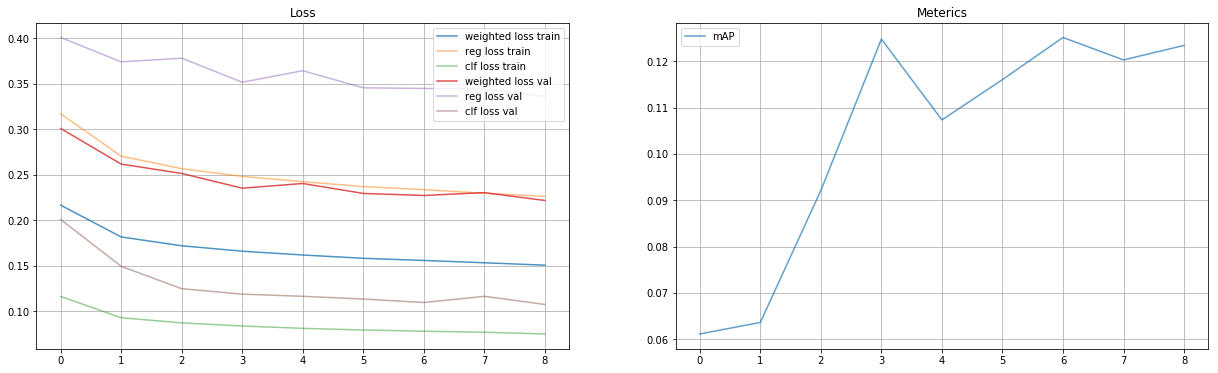

Threshold: 0.5095223784446716
../data/models/retinanet_resnet101_no_clf_last____/
[0.62140822 0.53123999]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


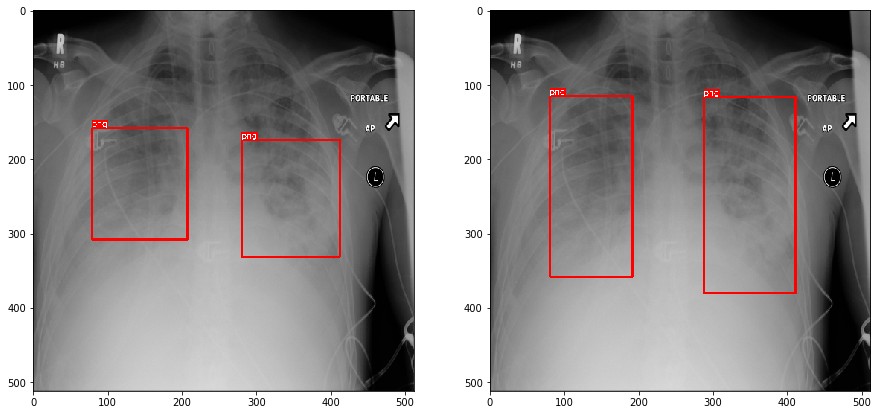

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.51967579]


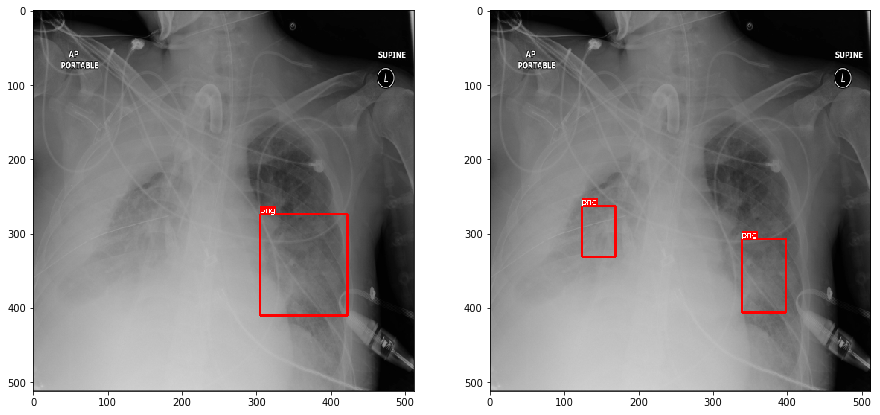

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


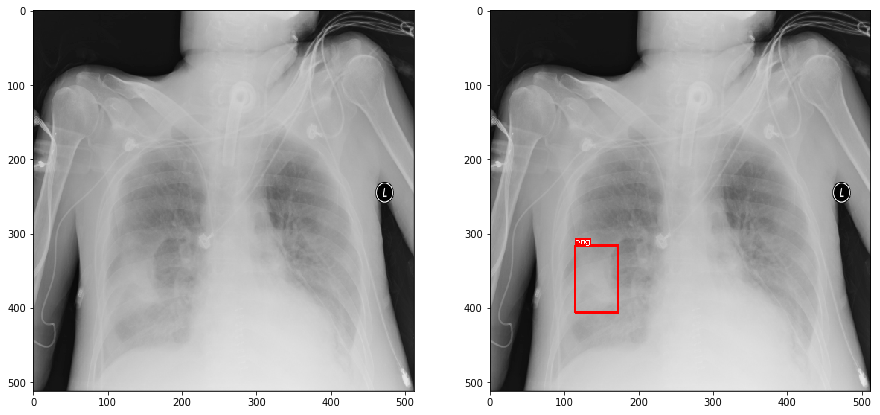

 61%|██████    | 520/849 [25:42<16:15,  2.97s/it]

In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last____/'

for fold in range(1, 4):
    train_datagen, val_datagen = get_datagens(paths_df, paths_df_val, df, ddf)
    focal_loss = retinanet.losses.FocalLoss(iou_lower=.2, iou_upper=.4)
    
    model = retinanet.model.resnet101(num_classes=1, focal_loss=focal_loss, pretrained=True, droprates=.3, single_channel=True, make_clf=False)
    model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])

    train_proc(model, fold, checkpoints_pth, train_datagen, val_datagen)

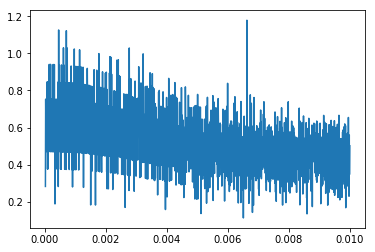

In [53]:
# datagen_params = {
#     'paths_df': paths_df, 
#     'paths_df_val': paths_df_val, 
#     'df': df, 
#     'class_ddf': ddf
# }

# focal_loss = retinanet.losses.FocalLoss(iou_lower=.12, iou_upper=.4)
# model = retinanet.model.resnet101(num_classes=1, pretrained=True, focal_loss=focal_loss, single_channel=True, dropouts=[], make_clf=False)
# model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])
# learner, lr_scheduler = find_lr(model, datagen_params)
# plt.plot([float(i) for i in lr_scheduler.history['lr']], [float(i) for i in lr_scheduler.history['bbx_clf_loss']])

In [24]:
def train_proc(model, fold, checkpoints_pth, datagen_params):
    lr_police = [[0, 3e-4], [1, 1e-5], [35, 1e-1]]

    history_pth = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold))
    history = None
    if os.path.isfile(history_pth):
        history = pickle.load(open(history_pth, 'rb'))
    train_datagen, val_datagen = get_datagens(fold=fold, val_to_train=.5, max_negatives=2000, **datagen_params)
    opt = torch.optim.Adam(model.parameters(), lr=lr_police[0][1], weight_decay=1e-4)

    for cll in range(len(lr_police) - 1):
        for param_group in opt.param_groups:
            param_group['lr'] = lr_police[cll][1]

        learner = RetinaLearner(model=model, opt=opt, loss=None, clf_loss=None, metrics=[], clf_reg_alpha=.5, ignored_keys=['clf_out'])

        last_epoch = -1
        if history is not None:
            n = len(history['val_losses'])
            last_epoch = n - max([ln[0] for ln in lr_police if ln[0] <= n]) - 1
        print('last_epoch: {}'.format(last_epoch))

        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(learner.opt, gamma=.87, last_epoch=last_epoch)
        learner, history = orchestrate(
            learner=learner, train_datagen=train_datagen, val_datagen=val_datagen, epochs=lr_police[cll + 1][0], epchs_per_save=3,
            lr_scheduler=lr_scheduler, fold=fold, checkpoints_pth=checkpoints_pth,
            history=history, nb_freezed_epchs=lr_police[cll + 1][0] + 1 if not cll else -1, df=df,
        )
    return learner

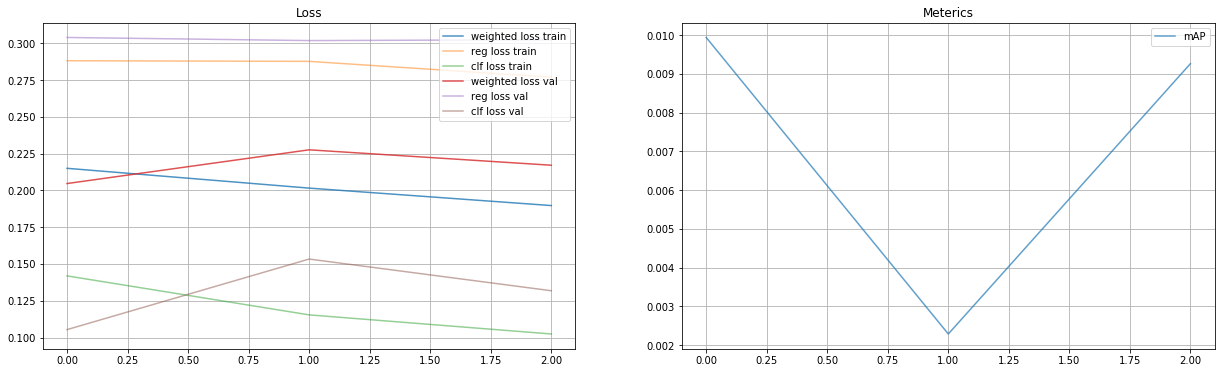

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Threshold: 0.1555066704750061
../data/models/retinanet_resnet101_no_clf_last_ultra/
[]


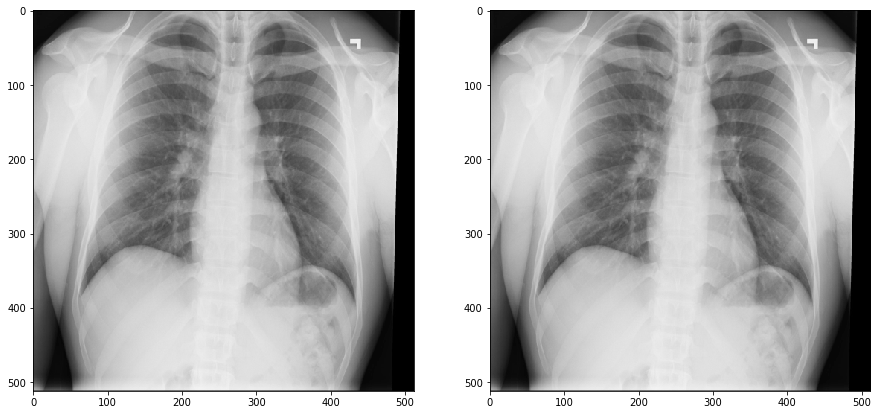

[]


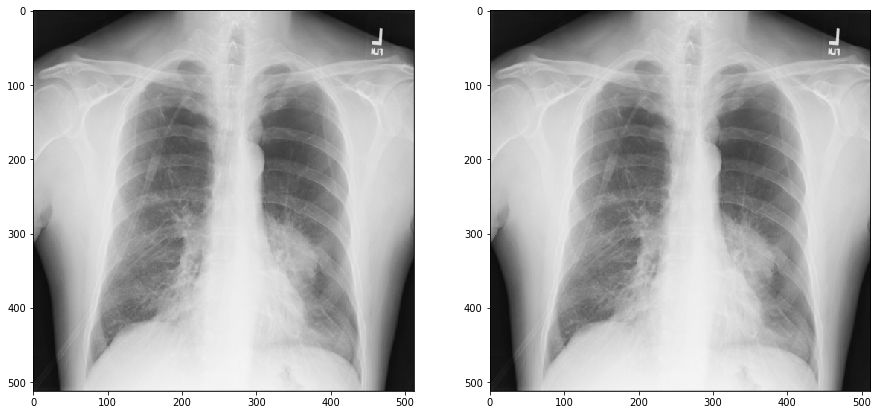

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]


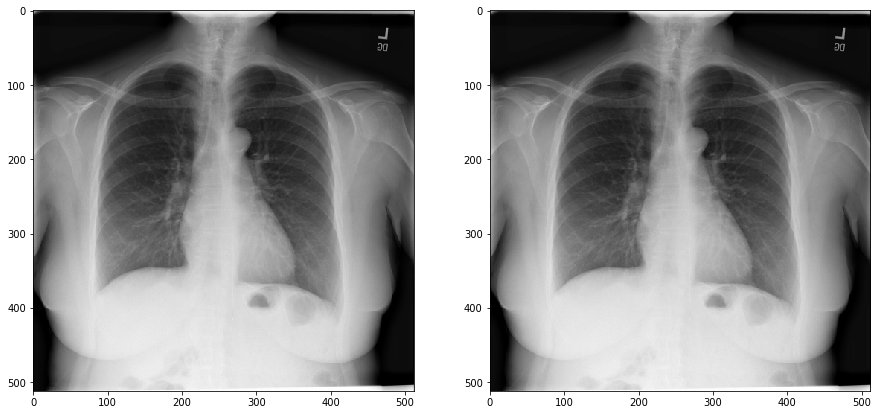

 79%|███████▊  | 2526/3211 [07:32<02:02,  5.58it/s]

KeyboardInterrupt: 

In [23]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last_ultra/'
datagen_params = {
    'paths_df': paths_df, 
    'df': df, 
    'class_ddf': ddf
}

for fold in range(4):
    focal_loss = retinanet.losses.FocalLoss(iou_lower=.12, iou_upper=.4)
    model = retinanet.model.resnet101(num_classes=1, pretrained=True, focal_loss=focal_loss, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])
    train_proc(model, fold, checkpoints_pth, datagen_params)

In [ ]:
checkpoints_pth = '../data/models/retinanet_resnet101_no_clf_last_ultra/'
datagen_params = {
    'paths_df': paths_df, 
    'df': df, 
    'class_ddf': ddf
}

for fold in range(1, 2):
    focal_loss = retinanet.losses.FocalLoss(iou_lower=.12, iou_upper=.4)
    model = retinanet.model.resnet101(num_classes=1, pretrained=True, focal_loss=focal_loss, single_channel=True, dropouts=[], make_clf=False)
    model = thf.get_model(model, checkpoint=None, devices=PARAMS['CUDA_DEVICES'])
    train_proc(model, fold, checkpoints_pth, datagen_params)

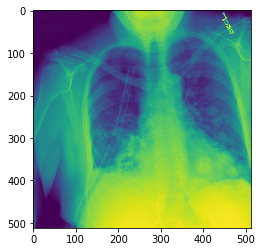

In [57]:
plt.imshow(train_datagen.dataset[0]['img'][0])

# INFERENCE

In [21]:
paths_df = pd.read_csv('../data/csv/stage_1_sample_submission.csv')
paths_df['ImageId'] = paths_df.patientId.apply(lambda x: x + '.dcm.png')
paths = ds.get_paths(paths_df, root_dir=PATHS['TEST'])

In [22]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
#     mirrs.append(np.rot90(np.array(im), axes=(1, 2), k=1))
#     mirrs.append(np.rot90(np.array(im), axes=(1, 2), k=2))
#     mirrs.append(np.rot90(np.array(im), axes=(1, 2), k=3))
    im = np.array(im)[:, :, ::-1]
    mirrs.append(np.array(im))
#     mirrs.append(np.rot90(np.array(im), axes=(1, 2), k=1))
#     mirrs.append(np.rot90(np.array(im), axes=(1, 2), k=2))
#     mirrs.append(np.rot90(np.array(im), axes=(1, 2), k=3))
    return np.concatenate(mirrs, axis=0)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
#     origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
#     origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
#     origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
#     origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
#     origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
#     origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return origs

In [23]:
class BBoxTestDataset(ds.BBoxDataset):
    """Coco dataset."""

    def __init__(self, paths, annotations, class_df, augmentations=None, inverse=False):
        """
        Args:
            root_dir (string): COCO directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        super(BBoxTestDataset, self).__init__(paths, annotations, class_df, augmentations, inverse)

    def load_image(self, meta):
        im_path = meta['image']
        image = [cv2.imread(im_path)]
        if 'inversed' in meta.keys():
            for inverse_id in range(self.inverse):
                im_path = os.path.join(meta['inversed'].format(inverse_id + 1))
                image.append(cv2.imread(im_path))
        return np.array(image)

    def load_label(self, key):
        return np.zeros((3, ))

    def postprocess(self, image, bboxes, key, label):
        image = np.expand_dims(np.mean(image, -1), -1).astype(np.uint8)
        image = _rotate_mirror_do(image)
        return { 
            'img': torch.stack([ds.img_transform(im) for im in image]),
            'annot': bboxes.astype(np.int),
            'pid': key,
            'label': label.astype(np.float32),
        }


In [24]:
dataset = BBoxTestDataset(paths, df, ddf, inverse=3)

In [25]:
paths['000924cf-0f8d-42bd-9158-1af53881a557.dcm.png']

{'image': '../data/test/png/000924cf-0f8d-42bd-9158-1af53881a557.dcm.png',
 'inversed': '../data/test/inversed/{}/000924cf-0f8d-42bd-9158-1af53881a557.dcm.png',
 'mask': '../data/test/masks/000924cf-0f8d-42bd-9158-1af53881a557.dcm.png'}

In [26]:
for data in dataset:
    break

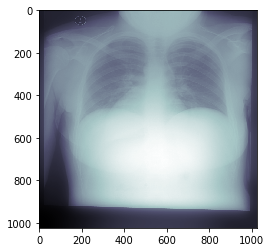

In [27]:
plt.imshow(data['img'].data.cpu().numpy()[5][0], cmap=plt.cm.bone)

In [28]:
def test_learner(learner, dataset, fold):
    learner.model.eval()
    mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
    std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
    bbox_trans = retinanet.utils.BBoxTransform(mean, std)
    clip_trans = retinanet.utils.ClipBoxes()
    make_anchors = retinanet.anchors.Anchors()

    for data in tqdm(dataset):
        preds = defaultdict(list)

        for i in range(NB_STEPS):
            image = torch.autograd.Variable(data['img'][i * STEP_SIZE: (i + 1) * STEP_SIZE]).cuda()
            if len(image.shape) == 3:
                image = image.float().unsqueeze(dim=0)

            output = learner.model(inputs=image.float(), test=True)

            image = image.data.cpu()
            for key in output.keys():
                output[key] = output[key].data.cpu()

            anchors = make_anchors(image).data.cpu()

            for i, el in enumerate(output['bb_reg_out']):
                bbox = bbox_trans(anchors, output['bb_reg_out'][i: i + 1])
                bbox = clip_trans(bbox, image)
                preds['bboxes'].append(bbox.numpy())

            preds['bb_clfs'].append(output['bb_clf_out'].numpy())
            preds['clfs'].append(output['clf_out'].numpy())

        preds['bb_clfs'] = np.array(preds['bb_clfs']).astype(np.float16).reshape(-1, 1)
        preds['bboxes'] = np.array(preds['bboxes']).astype(np.uint16).reshape(-1, 4)

        scores_over_thresh = (preds['bb_clfs'] > .05)[:, 0]
        preds['bboxes'] = preds['bboxes'][scores_over_thresh]
        preds['bb_clfs'] = preds['bb_clfs'][scores_over_thresh]


        preds['bboxes'] = np.array(preds['bboxes']).astype(np.uint16)
        preds['bb_clfs'] = np.array(preds['bb_clfs']).astype(np.float16)
        preds['clfs'] = np.array(preds['clfs']).astype(np.float16)
        np.savez(os.path.join(PATHS['TEST2'], 'preds', '{}'.format(fold), data['pid'][:-8]), **preds)

In [29]:
paths_df = pd.read_csv('../data/csv/stage_2_sample_submission.csv')
paths_df['ImageId'] = paths_df.patientId.apply(lambda x: x + '.dcm.png')
paths = ds.get_paths(paths_df, root_dir=PATHS['TEST2'])

In [33]:
fold = 0
OVERALL = 32
STEP_SIZE = 4

NB_STEPS = 2


LAST_EPOCH = 26

dataset = BBoxTestDataset(paths, df, ddf, inverse=3)
model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, num_classes_general=3, dropouts=[.2, .3], make_clf=True)
model = thf.get_model(model, checkpoint='../data/models/retinanet_resnet101/fold_{}_checkpoint.epoch_{}'.format(fold, LAST_EPOCH), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=clf_loss, metrics=[], clf_reg_alpha=.75, ignored_keys=['clf_out'])

Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight
Overlapped keys: 558


In [34]:
test_learner(learner, dataset, fold)

100%|██████████| 3000/3000 [47:43<00:00,  1.05it/s]


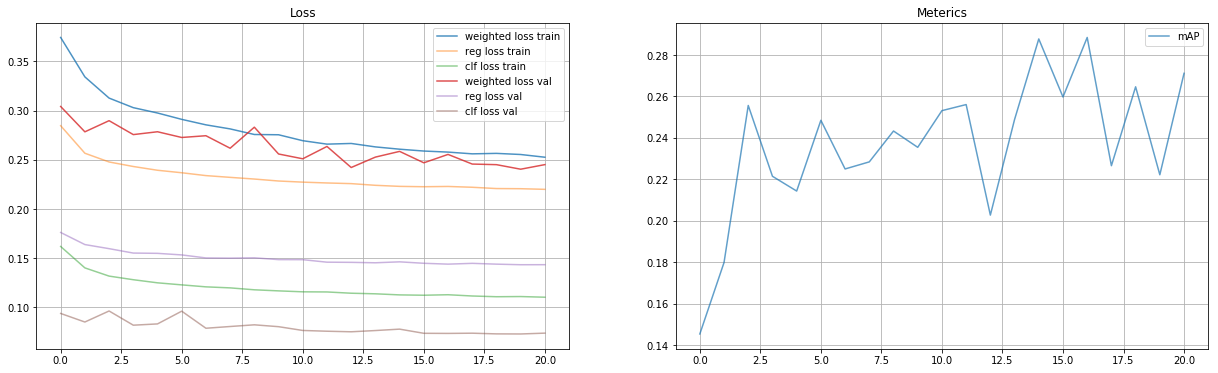

last_epoch: 19
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight
Overlapped keys: 558


In [35]:
fold = 1

checkpoints_pth = '../data/models/retinanet_resnet101'
history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
last_epoch = max(15, last_epoch)

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, inverse=3)
model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, num_classes_general=3, dropouts=[.2, .3], make_clf=True)
model = thf.get_model(model, checkpoint='../data/models/retinanet_resnet101/fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=clf_loss, metrics=[], clf_reg_alpha=.75, ignored_keys=['clf_out'])

In [36]:
test_learner(learner, dataset, fold)

100%|██████████| 3000/3000 [47:21<00:00,  1.06it/s]


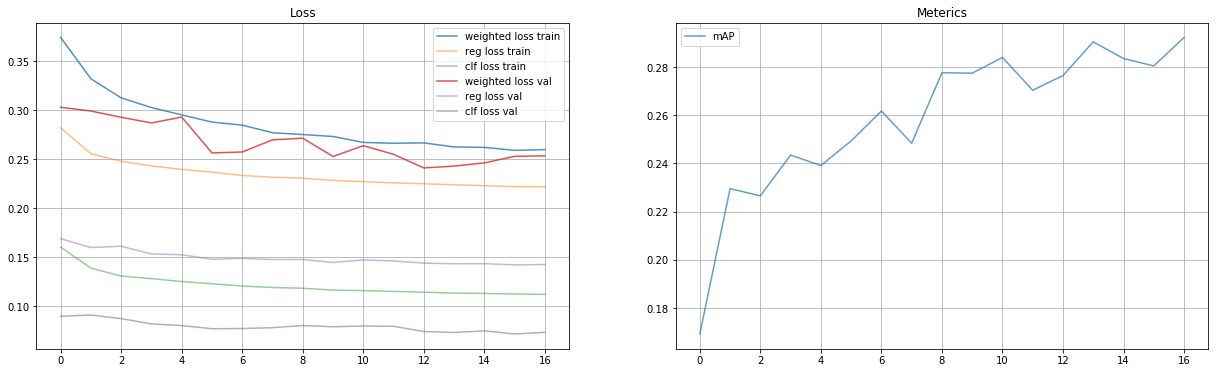

last_epoch: 15
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight
Overlapped keys: 558


In [37]:
fold = 2

checkpoints_pth = '../data/models/retinanet_resnet101'
history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
last_epoch = max(15, last_epoch)

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, inverse=3)
model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, num_classes_general=3, dropouts=[.2, .3], make_clf=True)
model = thf.get_model(model, checkpoint='../data/models/retinanet_resnet101/fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=clf_loss, metrics=[], clf_reg_alpha=.75, ignored_keys=['clf_out'])

In [38]:
test_learner(learner, dataset, fold)

100%|██████████| 3000/3000 [47:11<00:00,  1.06it/s]


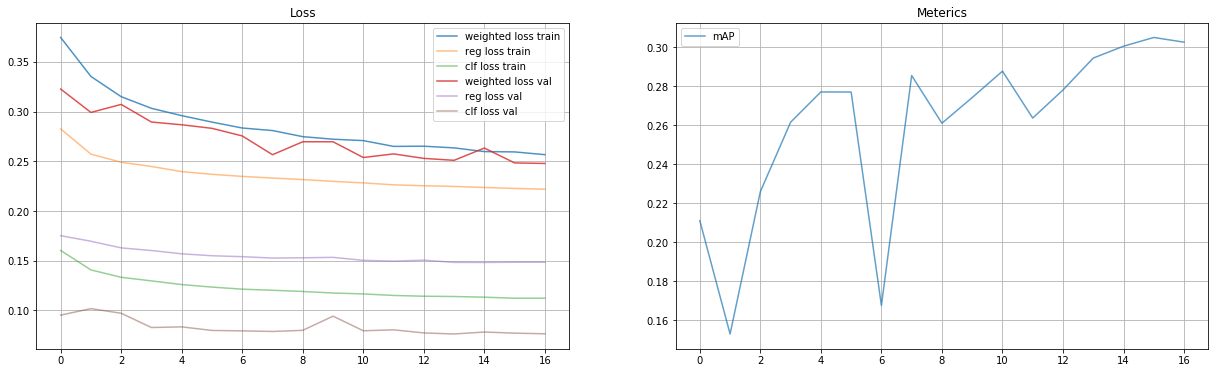

last_epoch: 15
Overlapped keys: 520
Poped keys: ['fc.weight', 'fc.bias']
Summed over: weight
Overlapped keys: 558


In [39]:
fold = 3

checkpoints_pth = '../data/models/retinanet_resnet101'
history = pickle.load(open(os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_loss'.format(fold)), 'rb'))
last_epoch = np.argmin([v['meters']['bbx_clf_loss'] for v in history['val_losses']])
last_epoch = max(15, last_epoch)

visualisation.plot_retina_losses(history)
print('last_epoch: {}'.format(last_epoch))

dataset = BBoxTestDataset(paths, df, ddf, inverse=3)
model = retinanet.model.resnet101(num_classes=1, pretrained=True, single_channel=True, num_classes_general=3, dropouts=[.2, .3], make_clf=True)
model = thf.get_model(model, checkpoint='../data/models/retinanet_resnet101/fold_{}_checkpoint.epoch_{}'.format(fold, last_epoch), devices=PARAMS['CUDA_DEVICES'])
learner = RetinaLearner(model=model, opt=None, loss=None, clf_loss=clf_loss, metrics=[], clf_reg_alpha=.75, ignored_keys=['clf_out'])

In [40]:
test_learner(learner, dataset, fold)

100%|██████████| 3000/3000 [48:01<00:00,  1.04it/s]


In [33]:
3.6 / 60

0.060000000000000005

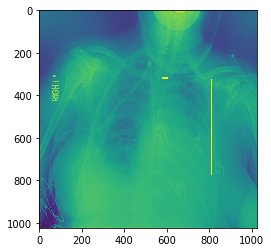

In [187]:
bbox = bboxes[3:, :, 194786].mean(0).astype(np.int)[0]

plt.imshow(visualisation.visualize_bbox(((image.data.cpu().numpy()[3, 0] * ds.STD + ds.MEAN) * 255).astype(np.uint8), bbox, 1, {1: 'pnm'}))

# Inference over dataset

In [35]:
import joblib

In [36]:
idir = os.path.join(PATHS['TEST2'])
mdir = os.path.join(PATHS['TEST2'], 'masks')
paths = glob(os.path.join(idir, 'png', '*.png'))
paths = [os.path.basename(path) for path in paths]
paths_df = pd.Series([separate(path) for path in paths], name='ImageId')
paths_df = pd.DataFrame(paths_df)

In [37]:
aug = lambda x: { k: cv2.resize(v, (256, 256)) for k, v in x.items() if v is not None}

In [38]:
paths = ds.get_paths(paths_df, root_dir=idir)
dataset = ds.CXR_Dataset(paths, augmentations=aug)
datagen = torch.utils.data.DataLoader(dataset,
                                      shuffle=False,
                                      batch_size=1,
                                      num_workers=0)

In [39]:
def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return np.array(mirrs)


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return origs

In [40]:
# plt.imshow((image[0, ..., 0] - ds.MEAN) / ds.STD)

In [41]:
last_iter = 190
checkpoints_pth = '../data/models/albunet_BNdec/'
checkpoints = os.path.join(checkpoints_pth, 'fold_{}_checkpoint.epoch_{}')

cnn_pool = list()
for fold in range(4):
    model = ternaus_net.AlbuNet(pretrained=True, decoder_block=ternaus_net.UnetBNDecoderBlock, single_channel=True)
    model = thf.get_model(model, checkpoint=checkpoints.format(fold, last_iter), devices=PARAMS['CUDA_DEVICES'])
    model.module.eval()
    cnn_pool.append(model)


Overlapped keys: 402
Overlapped keys: 402
Overlapped keys: 402
Overlapped keys: 402


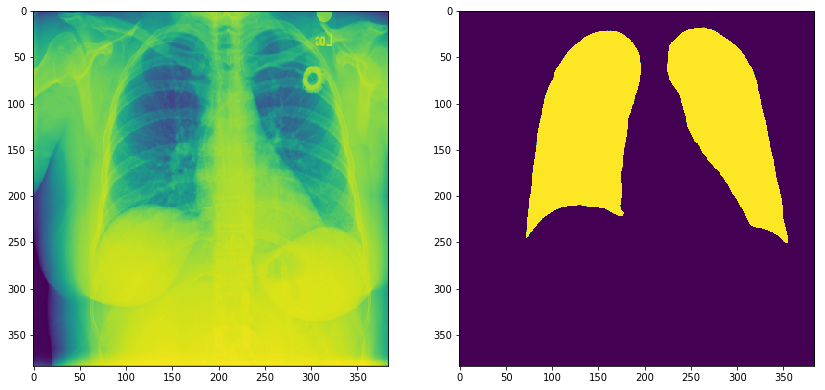


2901it [17:20,  2.79it/s]
2902it [17:21,  2.79it/s]
2903it [17:21,  2.79it/s]
2904it [17:21,  2.79it/s]
2905it [17:22,  2.79it/s]
2906it [17:22,  2.79it/s]
2907it [17:23,  2.79it/s]
2908it [17:23,  2.79it/s]
2909it [17:23,  2.79it/s]
2910it [17:24,  2.79it/s]
2911it [17:24,  2.79it/s]
2912it [17:24,  2.79it/s]
2913it [17:25,  2.79it/s]
2914it [17:25,  2.79it/s]
2915it [17:25,  2.79it/s]
2916it [17:26,  2.79it/s]
2917it [17:26,  2.79it/s]
2918it [17:26,  2.79it/s]
2919it [17:27,  2.79it/s]
2920it [17:27,  2.79it/s]
2921it [17:28,  2.79it/s]
2922it [17:28,  2.79it/s]
2923it [17:28,  2.79it/s]
2924it [17:29,  2.79it/s]
2925it [17:29,  2.79it/s]
2926it [17:30,  2.79it/s]
2927it [17:30,  2.79it/s]
2928it [17:30,  2.79it/s]
2929it [17:31,  2.79it/s]
2930it [17:31,  2.79it/s]
2931it [17:31,  2.79it/s]
2932it [17:32,  2.79it/s]
2933it [17:32,  2.79it/s]
2934it [17:32,  2.79it/s]
2935it [17:33,  2.79it/s]
2936it [17:33,  2.79it/s]
2937it [17:34,  2.79it/s]
2938it [17:34,  2.79it/s]
2939it [17:

In [42]:
for i, (k, v) in tqdm(enumerate(paths.items())):
    image = cv2.imread(v['image'])
    image = cv2.resize(image, (384, 384), interpolation=cv2.INTER_AREA)
    image = (image[..., :1] / 255. - ds.MEAN) / ds.STD
    images = _rotate_mirror_do(image)
    images = torch.tensor(np.rollaxis(images.astype(np.float32), 3, 1))

    with torch.no_grad():
        preds_ = list()
        images = torch.autograd.Variable(images).cuda()
        for cnn in cnn_pool:
            pred = torch.sigmoid(cnn(images))
            preds_.append(pred.data.cpu().numpy())

    preds = list()
    for pred in preds_:
        preds += _rotate_mirror_undo(np.rollaxis(pred, 1, 4))

    pred = 255 * np.median(np.array(preds) > .5, axis=0).squeeze()
    cv2.imwrite(os.path.join(mdir, k), pred.astype(np.uint8))

    if i % 100 == 0:
        clear_output()
        _, ax = plt.subplots(ncols=2, figsize=(14, 7))
        ax[0].imshow(np.squeeze(image))
        ax[1].imshow(np.squeeze(pred))
        plt.show()
